# Robust Varibad Analysis

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import cross_entropy_sampler as cem
import ido_utils as utils

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)

/tmp/ipykernel_57506/3532523605.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Configuration

In [72]:
BASE_PATH = f'logs/logs_{ENV_NAME}'
TRAIN_FILE = 'res.pkl'
TEST_FILE = 'test_res.pkl'

ENV_NAME = 'HalfCheetahVel-v0'
ENV_SHORT = 'hcv'
METHODS = ('varibad', 'cembad')
N_SEEDS = 2
SEED0 = 0

# EXPS = [
#     'hcv_cembad_1__04:10_00:25:27',
#     'hcv_cembad_2__04:10_00:25:19',
#     'hcv_varibad_1__04:10_00:25:15',
#     'hcv_varibad_2__04:10_00:25:11',
# ]

ALPHA = 0.05

FINISHED = True

In [119]:
get_dir = lambda method, seed: sorted([s for s in os.listdir(BASE_PATH) if s.startswith(f'{ENV_SHORT}_{method}_{seed}')])[-1]

# aggregate over episodes within task
def agg_eps(d):
    d['ret'] = d.ret.mean()
    d.drop('ep', axis=1, inplace=True)
    return d.head(1)

# aggregate over tasks within seed
def agg_tasks(d, fun):
    d['ret'] = fun(d.ret.values)
    d.drop('task', axis=1, inplace=True)
    if 'task_id' in d.columns:
        d.drop('task_id', axis=1, inplace=True)
    return d.head(1)

def cvar(x, alpha=ALPHA):
    return np.mean(sorted(x)[:int(np.ceil(alpha*len(x)))])

## Load results

#### Train / Validation

In [120]:
%%time
dd = pd.DataFrame()

for method in METHODS:
    for seed in range(SEED0, SEED0+N_SEEDS):
        e = get_dir(method, seed)
        d = pd.read_pickle(f'{BASE_PATH}/{e}/{TRAIN_FILE}')
        d['method'] = method
        d['seed'] = seed
        dd = pd.concat((dd, d))
        
dd.reset_index(drop=True, inplace=True)
print('Validation points:', len(pd.unique(dd.iter)))

if not FINISHED:
    # clip all trainings to the currently-shortest one
    n_steps = dd.groupby(['method','seed']).apply(lambda d: d.iter.max()).min()
    print(f'Removing iterations beyond {n_steps} ({100-100*(dd.iter<=n_steps).mean():.0f}% of the data).')
    dd = dd[dd.iter<=n_steps]

# aggregate episodes per task
dda = dd.groupby(['method','seed','iter','task_id'], sort=False).apply(agg_eps)
dda.reset_index(drop=True, inplace=True)

# aggregate tasks per seed
ddm = dda.groupby(['method','seed','iter'], sort=False).apply(lambda d: agg_tasks(d, np.mean))
ddc = dda.groupby(['method','seed','iter'], sort=False).apply(lambda d: agg_tasks(d, cvar))
ddm.reset_index(drop=True, inplace=True)
ddc.reset_index(drop=True, inplace=True)

# only first seed
dd0 = dd[dd.seed==SEED0]
dda0 = dda[dda.seed==SEED0]

dd

Validation points: 7
CPU times: user 536 ms, sys: 16.1 ms, total: 552 ms
Wall time: 542 ms


,iter,task_id,task,ep,ret,method,seed
0,-1,0,6.901375,0,-1461.737793,varibad,1
1,-1,0,6.901375,1,-1470.093384,varibad,1
2,-1,1,0.982758,0,-285.401062,varibad,1
3,-1,1,0.982758,1,-257.640137,varibad,1
4,-1,2,1.720833,0,-473.417236,varibad,1
...,...,...,...,...,...,...,...
891,149,13,0.170848,1,-99.585632,cembad,2
892,149,14,1.994499,0,-415.239288,cembad,2
893,149,14,1.994499,1,-412.726318,cembad,2
894,149,15,3.702322,0,-628.877991,cembad,2


#### Test

In [121]:
%%time
rr = None
if FINISHED:
    rr = pd.DataFrame()

    for method in METHODS:
        for seed in range(SEED0, SEED0+N_SEEDS):
            e = get_dir(method, seed)
            d = pd.read_pickle(f'{BASE_PATH}/{e}/{TEST_FILE}')
            d['method'] = method
            d['seed'] = seed
            rr = pd.concat((rr, d))

    rr.reset_index(drop=True, inplace=True)
    print('Test tasks:', len(d[d.ep==0]))
    
    # aggregate episodes per task
    rra = rr.groupby(['method','seed','task'], sort=False).apply(agg_eps)
    rra.reset_index(drop=True, inplace=True)
    rra

    # aggregate tasks per seed
    rrm = rra.groupby(['method','seed'], sort=False).apply(lambda d: agg_tasks(d, np.mean))
    rrc = rra.groupby(['method','seed'], sort=False).apply(lambda d: agg_tasks(d, cvar))
    rrm.reset_index(drop=True, inplace=True)
    rrc.reset_index(drop=True, inplace=True)

    # only first seed
    rr0 = rr[rr.seed==SEED0]
    rra0 = rra[rra.seed==SEED0]

rr

Test tasks: 1008
CPU times: user 3.86 s, sys: 31.7 ms, total: 3.89 s
Wall time: 3.88 s


,task,ep,ret,method,seed
0,4.563029,0,-763.558777,varibad,1
1,4.563029,1,-788.140625,varibad,1
2,2.613874,0,-499.141846,varibad,1
3,2.613874,1,-452.112274,varibad,1
4,6.796464,0,-1144.149292,varibad,1
...,...,...,...,...,...
8059,2.254684,1,-455.071930,cembad,2
8060,0.276930,0,-125.124855,cembad,2
8061,0.276930,1,-122.021980,cembad,2
8062,2.962788,0,-544.635437,cembad,2


## Analysis

### Tasks

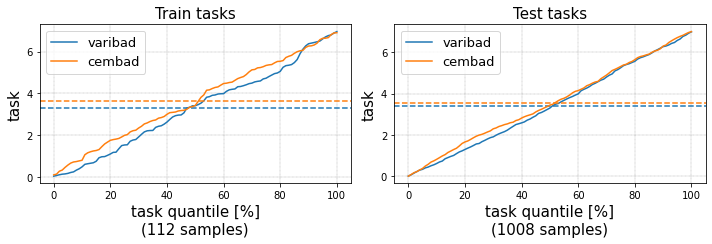

In [106]:
axs = utils.Axes(2, 2, fontsize=15)
a = 0

utils.qplot(dda0, 'task', 'task', 'method', axs[a])
axs.labs(a, title='Validation tasks')
a += 1

utils.qplot(rra0, 'task', 'task', 'method', axs[a])
axs.labs(a, title='Test tasks')
a += 1

plt.tight_layout();

#### Validation: all seeds

CPU times: user 2.51 s, sys: 10.9 ms, total: 2.52 s
Wall time: 2.51 s


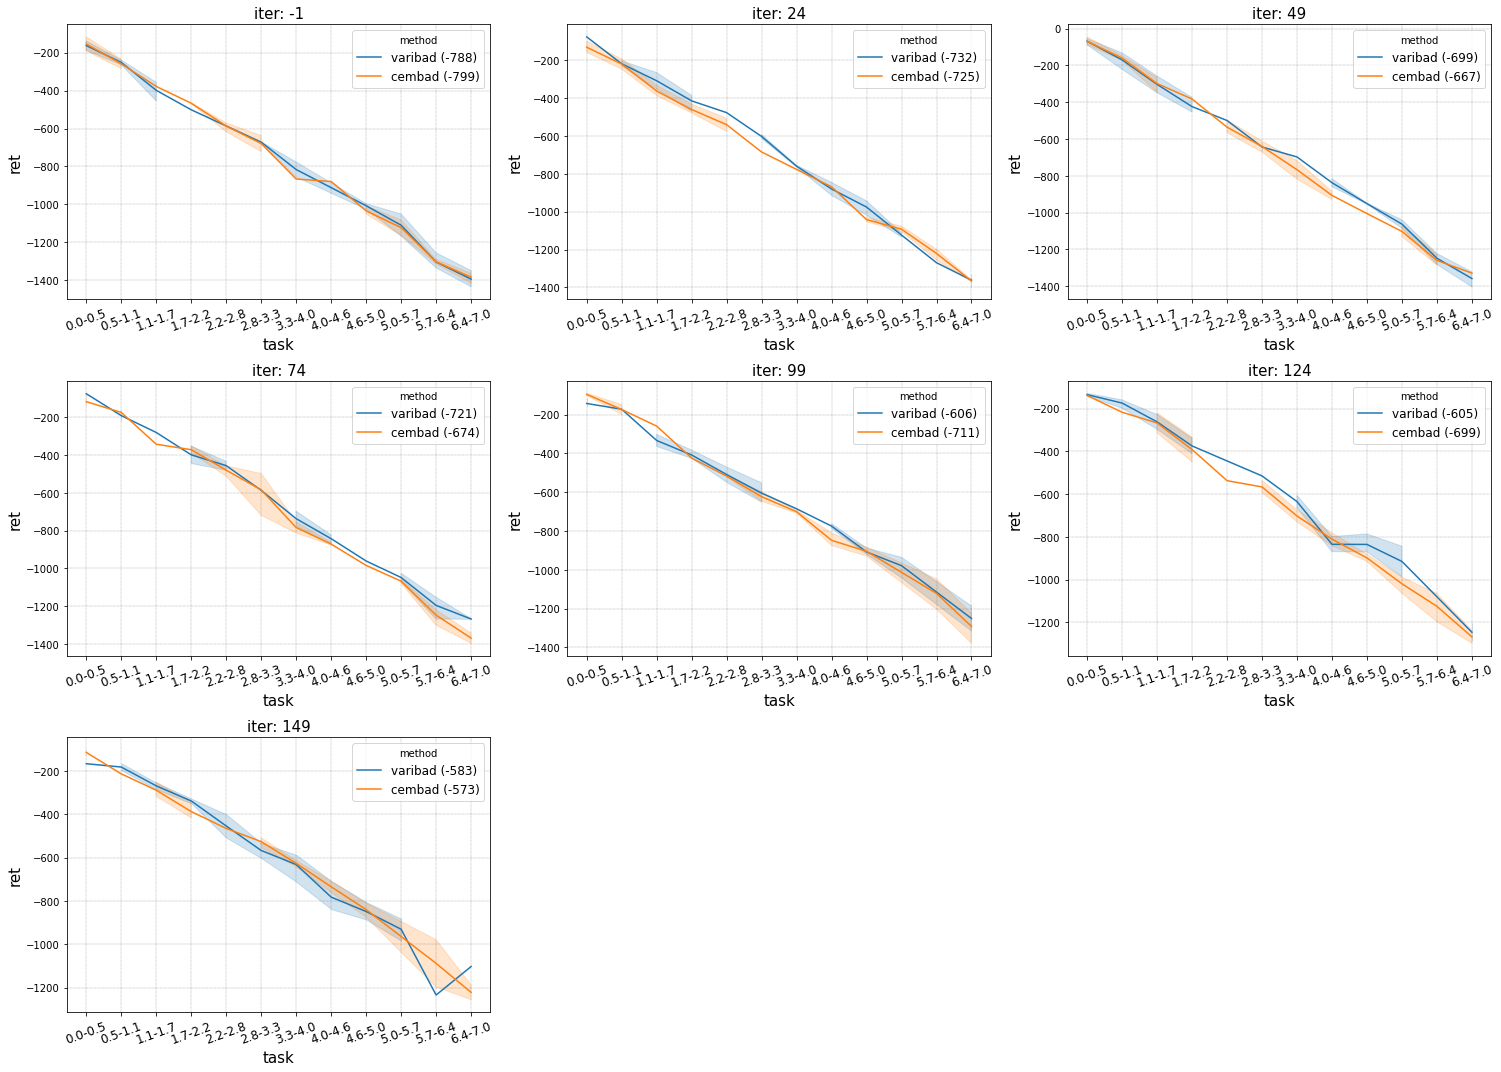

In [48]:
%%time
axs = utils.compare_quantiles(dda, 'task', 'ret', 'method', 'iter', xbins=13, fbins=7);

#### Test: first seed

CPU times: user 1.11 s, sys: 4.09 ms, total: 1.11 s
Wall time: 1.1 s


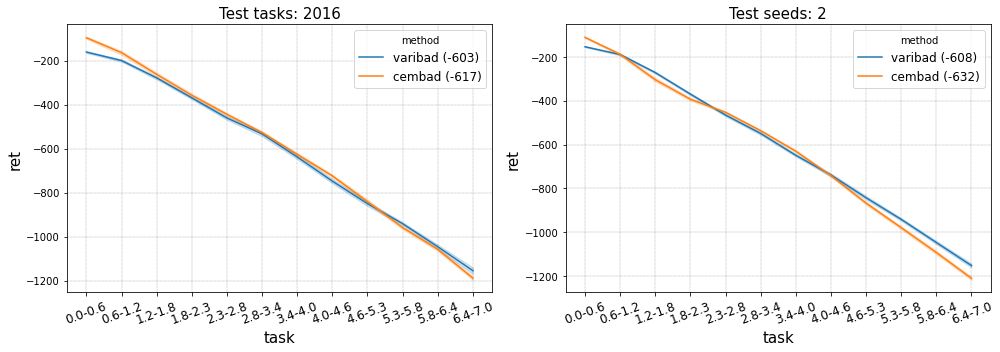

In [133]:
%%time
axs = utils.Axes(2, 2, axsize=(7,5), fontsize=15)
a = 0

axs = utils.compare_quantiles(rra0, 'task', 'ret', 'method', xbins=13, axs=axs, a0=a);
axs.labs(a, None, None, f'Test tasks: {len(pd.unique(rra0.task))}')
a += 1

axs = utils.compare_quantiles(rra, 'task', 'ret', 'method', xbins=13, axs=axs, a0=a);
axs.labs(a, None, None, f'Test seeds: {len(pd.unique(rra.seed))}')
a += 1

plt.tight_layout();

### The CEM: arbitrary seed

In [85]:
ce = cem.get_cem_sampler(ENV_NAME)
ce.load()

,title,batch,ref_quantile,internal_quantile,n_update_samples,update_samples_perc,beta_mean
0,hc_vel,0,-1432.602978,-1192.092926,26,20.31250,3.500000
1,hc_vel,1,-1399.455957,-1361.232792,26,20.31250,4.904557
2,hc_vel,2,-1427.135425,-1430.774931,31,24.21875,5.852332
3,hc_vel,3,-1453.455277,-1454.310194,27,21.09375,6.356166
4,hc_vel,4,-1471.941703,-1463.578074,26,20.31250,6.608083


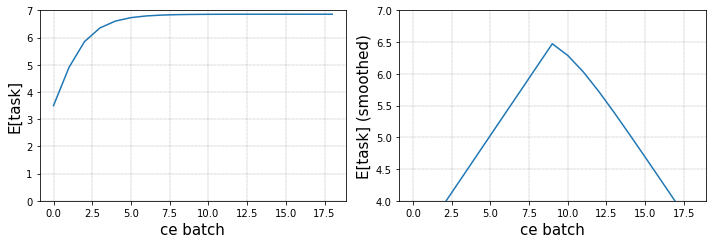

In [110]:
c1,c2 = ce.get_data()
c1['beta_mean'] = ce.vmax * c1.beta_mean

axs = utils.Axes(2, 2, fontsize=15)
axs[0].plot(c1.batch, c1.beta_mean)
axs[0].set_ylim((0,7))
axs.labs(0, 'ce batch', 'E[task]')

axs[1].plot(c1.batch, utils.smooth(c1.beta_mean, min(50,len(c1))))
axs[1].set_ylim((4,7))
axs.labs(1, 'ce batch', 'E[task] (smoothed)')

plt.tight_layout()

c1.head()

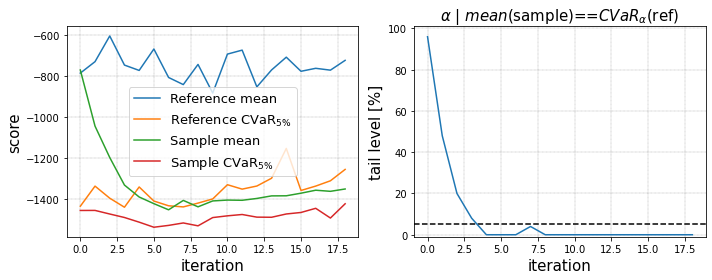

In [93]:
ce.show_summary();

### Validation results: first seed

CPU times: user 777 ms, sys: 7.94 ms, total: 785 ms
Wall time: 780 ms


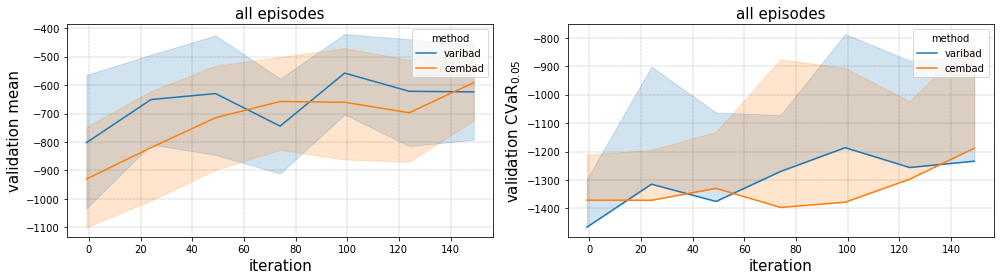

In [109]:
%%time

axs = utils.Axes(2, 2, (7,4), fontsize=15)
a = 0

sns.lineplot(data=dda0, x='iter', hue='method', y='ret', estimator='mean', ax=axs[a])
axs.labs(a, 'iteration', 'validation mean')
a += 1

sns.lineplot(data=dda0, x='iter', hue='method', y='ret', estimator=cvar, ax=axs[a])
axs.labs(a, 'iteration', f'validation CVaR$_{{{ALPHA}}}$')
a += 1

plt.tight_layout()

### Validation results: over seeds

CPU times: user 739 ms, sys: 0 ns, total: 739 ms
Wall time: 737 ms


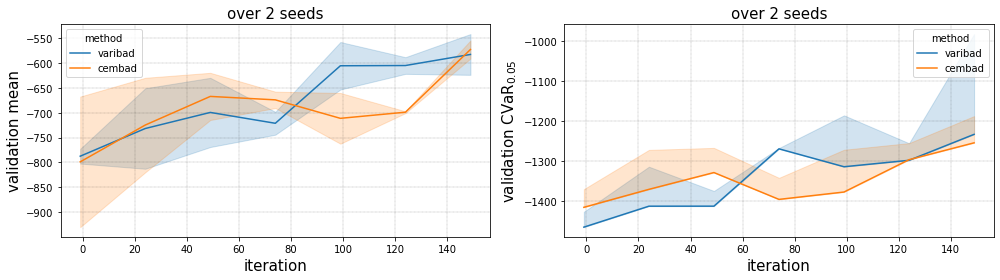

In [130]:
%%time

axs = utils.Axes(2, 2, (7,4), fontsize=15)
a = 0

sns.lineplot(data=ddm, x='iter', hue='method', y='ret', ax=axs[a])
axs.labs(a, 'iteration', 'validation mean', f'over {len(pd.unique(ddm.seed))} seeds')
a += 1

sns.lineplot(data=ddc, x='iter', hue='method', y='ret', estimator=cvar, ax=axs[a])
axs.labs(a, 'iteration', f'validation CVaR$_{{{ALPHA}}}$', f'over {len(pd.unique(ddc.seed))} seeds')
a += 1

plt.tight_layout()

### Test results: first seed

CPU times: user 2.56 s, sys: 0 ns, total: 2.56 s
Wall time: 2.56 s


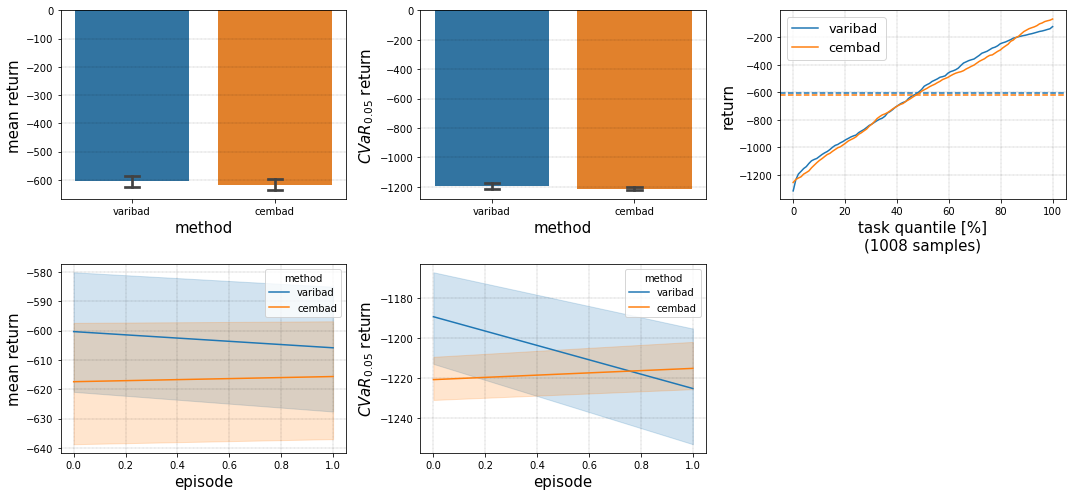

In [105]:
%%time
axs = utils.Axes(5, 3, fontsize=15)
a = 0

sns.barplot(data=rra0, x='method', y='ret', ci=95, capsize=0.1, ax=axs[a]);
axs.labs(a, 'method', 'mean return')
a += 1

sns.barplot(data=rra0, x='method', y='ret', ci=95, capsize=0.1, estimator=cvar, ax=axs[a]);
axs.labs(a, 'method', f'$CVaR_{{{ALPHA}}}$ return')
a += 1

utils.qplot(rra0, 'ret', 'task', 'method', q=np.linspace(0,1,100), ax=axs[a]);
axs[a].set_ylabel('return')
a += 1

sns.lineplot(data=rr0, x='ep', hue='method', y='ret', ax=axs[a])
axs.labs(a, 'episode', 'mean return')
a += 1

sns.lineplot(data=rr0, x='ep', hue='method', y='ret', estimator=cvar, ax=axs[a])
axs.labs(a, 'episode', f'$CVaR_{{{ALPHA}}}$ return')
a += 1

plt.tight_layout();

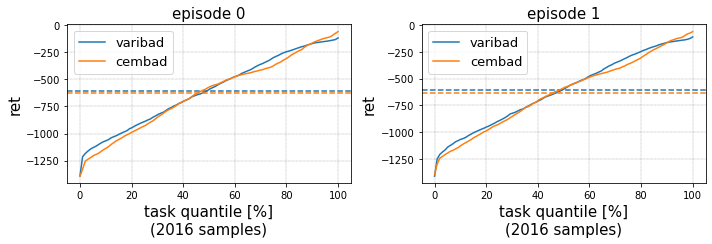

In [80]:
n_episodes = rr.ep.values[-1] + 1
axs = utils.Axes(n_episodes, min(n_episodes, 4), fontsize=15)

for ep in range(n_episodes):
    utils.qplot(rr0[rr0.ep==ep], 'ret', 'task', 'method', q=np.linspace(0,1,100), ax=axs[ep]);
    axs.labs(ep, title=f'episode {ep}', fontsize=15)
    
plt.tight_layout();

### Test results: over seeds

CPU times: user 262 ms, sys: 0 ns, total: 262 ms
Wall time: 257 ms


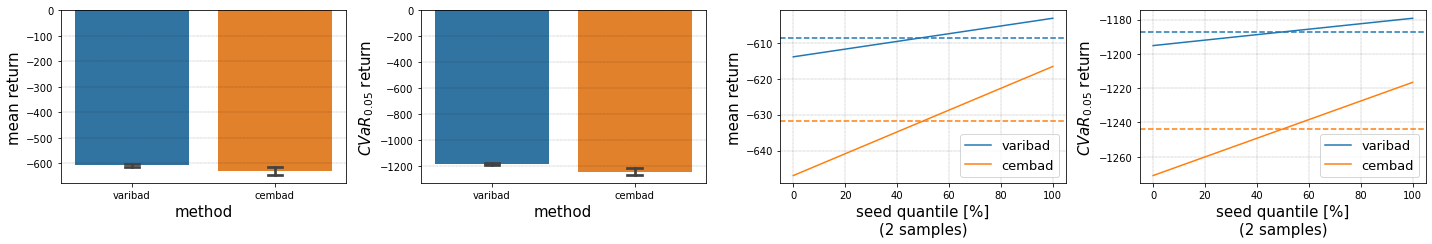

In [127]:
%%time
axs = utils.Axes(4, 4, fontsize=15)
a = 0

sns.barplot(data=rrm, x='method', y='ret', ci=95, capsize=0.1, ax=axs[a]);
axs.labs(a, 'method', 'mean return')
a += 1

sns.barplot(data=rrc, x='method', y='ret', ci=95, capsize=0.1, ax=axs[a]);
axs.labs(a, 'method', f'$CVaR_{{{ALPHA}}}$ return')
a += 1

utils.qplot(rrm, 'ret', 'seed', 'method', q=np.linspace(0,1,100), ax=axs[a]);
axs[a].set_ylabel('mean return')
a += 1

utils.qplot(rrc, 'ret', 'seed', 'method', q=np.linspace(0,1,100), ax=axs[a]);
axs[a].set_ylabel(f'$CVaR_{{{ALPHA}}}$ return')
a += 1

plt.tight_layout();